# Training a `torch` model
---

This notebook provides a simple implementation of a training loop for training a neural network with Pytorch.

In [2]:
import pkg_resources

run_colab = "google" in {pkg.key for pkg in pkg_resources.working_set}


if run_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    root = "/content/drive/MyDrive/DatSciEO"
    import sys
    sys.path.append(root)
else:
    root = "."

In [3]:
import datetime
import os
import time

import numpy as np

from models import TreeClassifConvNet
from utils import TreeClassifPreprocessedDataset

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

---
## Settings

In [4]:
# general training settings
N_epochs = 400
batch_size = 18
learning_rate = 1e-4
verbose = True

# where to save training progress info and checkpoints
run_dir = os.path.join(root, f"runs/{time.strftime('%Y%m%d-%Hh%Mm%Ss', time.localtime())}")
checkpoint_dir = os.path.join(run_dir, "checkpoints")

os.makedirs(run_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

In [5]:
# create datasets and dataloaders
dataset_dir = os.path.join(root, "data/1123_top10/1123_delete_nan_samples_")

dataset = TreeClassifPreprocessedDataset(
    dataset_dir,
    torchify=True
    )

# split the dataset into train and validation
splits = [.7, .3]
ds_train, ds_val = random_split(dataset, splits, generator=torch.Generator().manual_seed(42))

# define dataloaders for training
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

if verbose: print(
    f"\nUsing dataset with properties:\n"       \
    f"\tsamples:    {len(dataset)}\n"              \
    f"\t   train:   {len(ds_train)}\n"             \
    f"\t   val:     {len(ds_val)}\n"               \
    f"\tshape: {dataset[0][0].shape}\n"         \
    )


Using dataset with properties:
	samples:    10986
	   train:   7691
	   val:     3295
	shape: (30, 5, 5)



In [6]:
# model, loss and optimizer
model = TreeClassifConvNet(
    n_classes = dataset.n_classes,
    width = dataset.width,
    height = dataset.height,
    depth = dataset.depth
)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

TreeClassifConvNet(
  (model): Sequential(
    (0): Conv2d(30, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(7, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=125, out_features=10, bias=True)
  )
)

---
## Training
### Sanity Check
One final step before running the time-consuming loop is to perform a sanity check:
- is the GPU working?
- is the model able to learn? -> overfitting experiment on a small subset

<br>
Check whether the current device set to the GPU if available:

In [7]:
# device check
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("device:", device)
print("model: ", next(model.parameters()).device)

device: cpu
model:  cpu


Run an overfitting experiment with a small subset of the data.
The training loss should go to zero and the validation loss should explode:

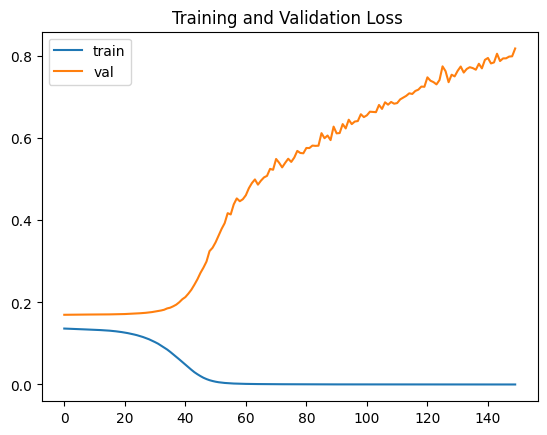

In [8]:
# save initial model state to recover after dummy training
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

# define some small datasets from subsets of the data
ds_train_check = TreeClassifPreprocessedDataset(dataset_dir, torchify=True, indices=[*range(50)])
# choose samples from the end of the dataset for validation to ensure class dissimilarity
ds_val_check = TreeClassifPreprocessedDataset(dataset_dir, torchify=True, indices=[*range(len(dataset)-42, len(dataset))])


dl_train_check = DataLoader(ds_train_check, batch_size, shuffle=True)
dl_val_check = DataLoader(ds_val_check, batch_size, shuffle=True)
n_train_check, n_val_check = len(ds_train_check), len(ds_val_check)

# train a few epochs and observe training and validation error
losses_train = []
losses_val = []

for i_epoch in range(150):

    model.train()
    running_loss = 0.
    for i_batch, (x, y) in enumerate(dl_train_check):
        assert torch.isnan(x).sum() == 0, "NaN in trainings data, please fix."

        x = x.float().to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        running_loss += loss.item()

        optim.step()
        optim.zero_grad()

    model.eval()
    running_loss_val = 0.
    with torch.no_grad():
        for i_batch_val, (x, y) in enumerate(dl_val_check):
            x = x.float().to(device)
            y = y.to(device)
            
            pred_val = model(x.float().to(device))

            loss_val = loss_fn(pred_val, y)
            running_loss_val += loss_val.item()

    losses_train.append(running_loss / n_train_check)
    losses_val.append(running_loss_val / n_val_check)

fig = plt.figure()
plt.title("Training and Validation Loss ")
plt.plot(losses_train, label="train")
plt.plot(losses_val, label="val")
plt.legend()

# after dummy training, restore initial state
checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint['model'])
optim.load_state_dict(checkpoint['optimizer'])
os.remove("checkpoint.pth")

### Training Loop
After defining all the necessary parameters above, we can finally run the training loop.
In the real training loop, for each epoch following metrics are calculated:
- average running training loss over the whole epoch
- average validation loss after epoch
- training accuracy after epoch
- validation accuracy after epoch

The metrics are also logged with the help of the `tensorboard` package and can be viewed by...
- running `tensorboard --logdir=<YOUR_LOG_DIR>`
- then visiting [http://localhost:6006/](http://localhost:6006/)

In [9]:
# training loop
writer = SummaryWriter(run_dir)

t0 = time.time()
last_info = t0
n_train = len(dl_train.dataset)
n_batch_train = np.ceil(n_train/batch_size)
its_total = n_batch_train * N_epochs
n_val = len(dl_val.dataset)
n_batch_val = np.ceil(n_val/batch_size)

for i_epoch in range(N_epochs):

    running_loss = 0.
    last_loss = 0.
    correct = 0

    model.train()
    for i_batch, (x, y) in enumerate(dl_train):
        assert torch.isnan(x).sum() == 0, "NaN in trainings data, please fix."

        x = x.float().to(device)
        y = y.to(device)

        pred = model(x)

        loss = loss_fn(pred, y)
        running_loss += loss.item()
        loss.backward()

        optim.step()
        optim.zero_grad()

        if verbose and (((time.time() - last_info) > 20) or (i_batch % (n_batch_train//10) == 0)):
            loss_avg = running_loss / (i_batch+1) # loss per batch
            last_info = time.time()
            loss, current = loss.item(), (i_batch + 1) * len(x)
            curr_it = i_epoch*n_train + i_batch+1
            t_per_it = (time.time()-t0) / curr_it
            ETA = (its_total - curr_it) * t_per_it
            writer.add_scalar("train_intermediate/loss", loss_avg, i_epoch+current/n_train)
            print(f"train:  {loss:>7f}  loss avg: {loss_avg:>7f}   [epoch {i_epoch:>3d}: {current:>5d}/{n_train:>5d}]\t\tt/it {t_per_it:.2f}\tETA {datetime.timedelta(seconds=ETA)}")

    all = [(el, y_) for x, y in dl_train for el, y_ in zip(np.argmax(model(x.float().to(device)).detach().cpu().numpy(), axis=1), y.detach().cpu().numpy())]
    all_preds = [a[0] for a in all]
    all_gts = [a[1] for a in all]
    accuracy_train = accuracy_score(all_gts, all_preds)

    t_per_epoch = (time.time()-t0)/(i_epoch+1)

    loss_avg = running_loss / n_train
    if verbose: print(f"train:  {loss:>7f}  loss avg: {loss_avg:>7f}   [epoch {i_epoch:>3d}: {n_train:>5d}/{n_train:>5d}]\t\tt/epoch {t_per_epoch}")
    if verbose: print(f"        {loss:>7f}  accuracy: {accuracy_train:>7f}")


    # validation loop
    model.eval()
    running_loss_val = 0.
    correct = 0
    with torch.no_grad():
        for i_batch_val, (x, y) in enumerate(dl_val):
            x = x.float().to(device)
            y = y.to(device)

            pred_val = model(x)

            pred_class = np.argmax(pred_val.cpu().numpy(), axis=1)
            correct == (pred_class == y.cpu().numpy()).sum()

            loss_val = loss_fn(pred_val, y)
            running_loss_val += loss_val

    accuracy_val = correct / n_val
    loss_val_avg = running_loss_val / n_val

    if verbose: print(f"val:    loss avg: {loss_val_avg:>7f}   [epoch {i_epoch:>3d}]")
    if verbose: print(f"        accuracy: {loss_val_avg:>7f}")

    # write some metrics to tensorboard
    writer.add_scalars("_train_val/loss", {"train": loss_avg, "val": loss_val_avg}, i_epoch+1)
    writer.add_scalars("_train_val/accuracy", {"train": accuracy_train, "val": accuracy_val}, i_epoch+1)
    writer.add_scalar("train/loss", loss_avg, i_epoch+1)
    writer.add_scalar("train/accuracy", accuracy_train, i_epoch+1)
    writer.add_scalar("val/loss", loss_val_avg, i_epoch+1)
    writer.add_scalar("val/accuracy", accuracy_val, i_epoch+1)

    checkpoint_file = os.path.join(checkpoint_dir, f"epoch_{i_epoch}.pth")
    if verbose: print(f"Saving current state to '{checkpoint_file}'\n")
    torch.save({
            'epoch': i_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
            }, checkpoint_file)


train:  2.292817  loss avg: 2.292817   [epoch   0:    18/ 7691]		t/it 0.17	ETA 3:05:43.780457
train:  2.298388  loss avg: 2.295602   [epoch   0:    36/ 7691]		t/it 0.14	ETA 2:34:26.311167
train:  2.295323  loss avg: 2.295509   [epoch   0:    54/ 7691]		t/it 0.14	ETA 2:30:22.738958
train:  2.306276  loss avg: 2.298201   [epoch   0:    72/ 7691]		t/it 0.17	ETA 2:59:27.482433
train:  2.301334  loss avg: 2.298828   [epoch   0:    90/ 7691]		t/it 0.16	ETA 2:49:47.993760
train:  2.297490  loss avg: 2.298605   [epoch   0:   108/ 7691]		t/it 0.15	ETA 2:43:11.311511
train:  2.297935  loss avg: 2.298509   [epoch   0:   126/ 7691]		t/it 0.15	ETA 2:36:13.247832
train:  2.292741  loss avg: 2.297788   [epoch   0:   144/ 7691]		t/it 0.14	ETA 2:30:03.570623
train:  2.295990  loss avg: 2.297588   [epoch   0:   162/ 7691]		t/it 0.16	ETA 2:49:04.522473
train:  2.314788  loss avg: 2.299308   [epoch   0:   180/ 7691]		t/it 0.16	ETA 2:47:57.665818
train:  2.298724  loss avg: 2.299255   [epoch   0:   198/ 76

RuntimeError: File .\runs/20231218-19h48m28s\checkpoints\epoch_0 cannot be opened.